# odc-stac

## Background

### Why use odc-stac?

The Digital Earth Africa Analysis Sandbox is a cloud-based user computational platform that operates through a managed Jupyter Lab environment. 
This environment provides users with direct access to an installed and pre-configured Open Data Cube instance containing all of Digital Earth Africa's earth observation data. 
The Analysis Sandbox also provides users with limited computing resources for interacting with and analyzing Digital Earth Africa's earth observation data. 
To use the Digital Earth Africa Analysis Sandbox, open http://sandbox.digitalearth.africa/ in your browser, and follow the instructions [here](https://docs.digitalearthafrica.org/en/latest/sandbox/access.html) to create an account and get started. 

Some of the limitations of using the Analysis Sandbox include:

- Being a managed environment, the user is limited in how much they can customize the Analysis Sandbox to suit their needs. If you wish to use modules/packages outside the pre-loaded packages in the default Analysis Sandbox, you will need to reinstall them everytime you start up your Analysis Sandbox environment as they do not persist. 

- Carrying out an analysis over a large area like an entire country or for the entire continent of Africa can be challenging even with the larger 32GB environment  provided. 

- Accessing datasets from sources other than Digital Earth Africa requires downloading the data onto your local machine, then uploading the data into the Analysis Sandbox. 

The `odc-stac` can is a suitable alternative to using the Analyis Sandbox. 
The `odc-stac` is a set of tools for converting [STAC](https://stacspec.org/en) metadata to the [Open Data Cube](https://www.opendatacube.org/) data model.
`odc-stac` allows you to load STAC items into `xarray` Datasets, and process them locally or disribute data loading and computation with [Dask](https://dask.org/).

**Table 1: Comparison between ODC and STAC concepts.**

| STAC       | ODC                    | Description                                      | 
| :--        | :--                    | :--                                              |
| [Collection](https://pystac.readthedocs.io/en/latest/api/pystac.html#pystac.Collection) | [Product](https://opendatacube.readthedocs.io/en/latest/about-core-concepts/products.html) or [DatasetType](https://datacube-core.readthedocs.io/en/latest/api/core-classes/datasetType.html#datacube.model.DatasetType) | Collection of observations across space and time |
| [Item](https://pystac.readthedocs.io/en/latest/api/pystac.html#pystac.Item)      | [Dataset](https://datacube-core.readthedocs.io/en/latest/api/core-classes/dataset.html#datacube.model.Dataset)                | Single observation (specific time and place), multi-channel |
| [Asset](https://pystac.readthedocs.io/en/latest/api/pystac.html#pystac.Asset)      | [Measurement](https://datacube-core.readthedocs.io/en/latest/api/core-classes/measurement.html#datacube.model.Measurement)           | Component of a single observation |
| [Band](https://github.com/stac-extensions/eo#band-object)         | [Measurement](https://datacube-core.readthedocs.io/en/latest/api/core-classes/measurement.html#datacube.model.Measurement)             | Pixel plane within a multi-plane asset |
| [Common Name](https://github.com/stac-extensions/eo#common-band-names)  | Alias                  | Refer to the same band by different  |

Digital Earth Africa stores a range of data products on Amazon Web Service's Simple Cloud Storage (S3) with free public access. 
Digital Earth Africa also provides a SpatioTemporal Asset Catalog (STAC) endpoint for listing or searching the metadata, e.g. bounding box (area of interest coordinates), collection and date and time, for this archive here: https://explorer.digitalearth.africa/stac.
Using the STAC endpoint provided, the `odc-stac` module gives you the ability to access Digital Earth Africa's earth observation data outside of the Analysis Sandbox, on your own resources, whether locally or on a cloud service such as Amazon Web Services (AWS), from the python environment of your choice, in the same format (as an `xarray.Dataset`) as you would in the Analysis Sandbox. You can also use `odc-stac` to load other STAC compliant earth observation data as an `xarray.Dataset`.

### Getting started with odc-stac

Instructions on how to install the `odc-stac` module into your Python environment are provided [here](https://odc-stac.readthedocs.io/en/latest/intro.html#installation). 

Example notebooks on how you can use `odc-stac` can be viewed here:

- [Access Sentinel 2 Analysis Ready Data from Digital Earth Africa](https://odc-stac.readthedocs.io/en/latest/notebooks/stac-load-S2-deafrica.html)

- [Access Sentinel 2 Data from AWS](https://odc-stac.readthedocs.io/en/latest/notebooks/stac-load-e84-aws.html#)

- [Access Sentinel 2 Data on Planetary Computer](https://odc-stac.readthedocs.io/en/latest/notebooks/stac-load-S2-ms.html)

To download and run this notebooks, visit the [odc-stac Github repository](https://github.com/opendatacube/odc-stac/tree/develop/notebooks).

For more on the `odc-stac` see the [odc-stac documentation](https://odc-stac.readthedocs.io/en/latest) and the [odc-stac Github repository](https://github.com/opendatacube/odc-stac).

## Description

This notebook demonstrate a simple analysis workflow based on the Digital Earth Africa Annual Landsat-8 and Landsat-9 GeoMAD product. 

We will load the Annual Landsat-8 and Landsat-9 GeoMAD data using the `odc` `stac_load` function then calculate the Modified Normalized Difference Water Index (MNDWI).
We will then compare the results of the water classification of the MNDWI index to the WOfS Annual Summaries product. 

## Load Packages

In [11]:
import pprint

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from get_product_config import get_product_config
from pystac_client import Client

from odc.stac import configure_rio, stac_load

## Set Collection Configuration

The purpose of the configuration dictionary is to supply some optional STAC extensions that a data source might be missing. This missing information includes,  pixel data type, nodata value, unit attribute and band aliases. The configuration dictionary is passed to the `odc.stac.load` `stac_cfg=` parameter in order to supply the missing information at load time. 

The configuration is per collection per asset and is determined from the product's definition. The Annual Landsat-8 and Landsat-9 GeoMAD product definition is available at https://explorer.digitalearth.africa/products/gm_ls8_ls9_annual.

In [13]:
product_name = "gm_ls8_ls9_annual"
# Set the profile to specify that the product is a Digital Earth Africa product.
profile = "deafrica"
config = get_product_config(product_name, profile)
pprint.pprint(config)

{'gm_ls8_ls9_annual': {'aliases': {'BCDEV': 'BCMAD',
                                   'EDEV': 'EMAD',
                                   'SDEV': 'SMAD',
                                   'band_2': 'SR_B2',
                                   'band_3': 'SR_B3',
                                   'band_4': 'SR_B4',
                                   'band_5': 'SR_B5',
                                   'band_6': 'SR_B6',
                                   'band_7': 'SR_B7',
                                   'bcdev': 'BCMAD',
                                   'bcmad': 'BCMAD',
                                   'blue': 'SR_B2',
                                   'count': 'COUNT',
                                   'edev': 'EMAD',
                                   'emad': 'EMAD',
                                   'green': 'SR_B3',
                                   'nir': 'SR_B5',
                                   'red': 'SR_B4',
                                   'sdev': 'SMAD',
  

## Set AWS Configuration

Digital Earth Africa data is stored on S3 in Cape Town, Africa. To load the data, we must configure rasterio with the appropriate AWS S3 endpoint. This can be done with the `odc.stac.configure_rio` function. Documentation for this function is available at https://odc-stac.readthedocs.io/en/latest/_api/odc.stac.configure_rio.html#odc.stac.configure_rio.

The configuration below must be used when loading any Digital Earth Africa data through the STAC API.

In [21]:
odc.stac.configure_rio(
    cloud_defaults=True,
    aws={"aws_unsigned": True},
    AWS_S3_ENDPOINT="s3.af-south-1.amazonaws.com",
)

AttributeError: module 'odc.stac' has no attribute 'configure_rio'

## Connect to the Digital Earth Africa STAC Catalog

In [ ]:
# Open the stac catalogue.
catalog = Client.open("https://explorer.digitalearth.africa/stac")

## Find STAC Items to Load

### Define query parameters

>**Note**: The Annual  Landsat-8 and Landsat-9 GeoMAD composite is available for the years **2021** - **present**.

One way to set the study area/bounding box is to set a central latitude and longitude coordinate pair, `(central_lat, central_lon)`, then specify how many degrees to include either side of the central latitude and longitude, known as the `buffer`.
Together, these parameters specify a square study area, as shown below:

<img src=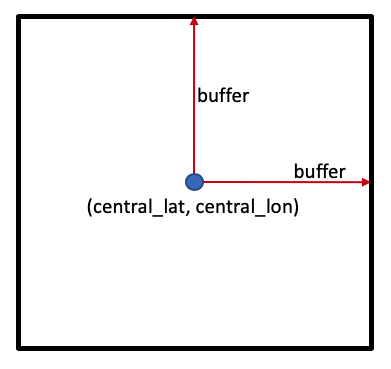 width="250" height="250">

In [ ]:
# Set the central latitude and longitude.
central_lat = -5.9460
central_lon = 35.5188

# Set the buffer to load around the central coordinates.
buffer = 0.03

# Compute the bounding box for the study area
study_area_lat = (central_lat - buffer, central_lat + buffer)
study_area_lon = (central_lon - buffer, central_lon + buffer)

# Set the bounding box.
# [xmin, ymin, xmax, ymax] in latitude and longitude (EPSG:4326).
bbox = [study_area_lon[0], study_area_lat[0], study_area_lon[1], study_area_lat[1]]

In [ ]:
# Set a start and end date.
start_date = "2021"
end_date = "2021"

# Set the STAC collections.
collections = [product_name]

### Construct a query and get items from the Digital Earth Africa STAC Catalog

In [ ]:
# Build a query with the set parameters
query = catalog.search(
    bbox=bbox, collections=collections, datetime=f"{start_date}/{end_date}"
)

# Search the STAC catalog for all items matching the query
items = list(query.get_items())
print(f"Found: {len(items):d} datasets")

## Load the GeoMAD data 

In this step, we specify the desired coordinate system, resolution (here 30m), and bands to load.  We will load 2 spectral satellite bands: `green` and `swir_1`. Since the band aliases are contained in the `config` dictionary, bands can be loaded using these aliases instead of the band number e.g. `"swir_1"` instead of `"SR_B6"`. 

We also pass the bounding box to the `stac_load` function to only load the requested data. The data will be lazy-loaded with dask, meaning that is won't be loaded into memory until necessary, such as when it is displayed.

In [ ]:
# Specify the bands to load, the desired crs and resolution.
measurements = ("green", "swir_1")
crs = "EPSG:6933"
resolution = 30

In [ ]:
# Load the dataset.
ds_ls = stac_load(
    items,
    bands=measurements,
    crs=crs,
    resolution=resolution,
    chunks={},
    stac_cfg=config,
    bbox=bbox,
).squeeze()

In [ ]:
# View the xarray.Dataset.
ds_ls

## Compute the MNDWI index

After loading the data, you can perform standard `xarray` operations, such as calculating the Modified Normalized Difference Water Index (MNDWI).

$$
\begin{aligned}
\text{MNDWI} = \frac{\text{Green} - \text{SWIR}}{\text{Green} + \text{SWIR}}
\end{aligned}
$$

>**Note:** The `.compute()` method triggers Dask to load the data into memory.

In [ ]:
# Normalize the data by dividing the data by 10,000.
ds_ls = ds_ls / 10000
# Calculate the MNDWI index.
ds_ls["MNDWI"] = (ds_ls.green - ds_ls.swir_1) / (ds_ls.green + ds_ls.swir_1)
# Convert the xarray.Dataset to a DataArray.
mndwi = ds_ls.MNDWI.compute()

If a pixel's `MNDWI` value is greater than `0`, i.e. `MNDWI`>`0` then the pixel is classified as water.

In [ ]:
water_mndwi = mndwi.where(mndwi > 0.5, np.nan)
water_mndwi = water_mndwi.where(np.isnan(water_mndwi), 1)

## Load the WOfS Annual Summaries

In [ ]:
# Set the collection configuration.
product_name = "wofs_ls_summary_annual"
config = get_product_config(product_name, profile)

# Set the STAC collections.
collections = [product_name]

# Build a query with the set parameters.
query = catalog.search(
    bbox=bbox, collections=collections, datetime=f"{start_date}/{end_date}"
)

# Search the STAC catalog for all items matching the query.
items = list(query.get_items())
print(f"Found: {len(items):d} datasets")

In [ ]:
# Specify the bands to load.
measurements = "frequency"

# Load the dataset.
ds_wofs_annual = stac_load(
    items,
    bands=measurements,
    crs=crs,
    resolution=resolution,
    chunks={},
    stac_cfg=config,
    bbox=bbox,
).squeeze()

# View the xarray.Dataset.
ds_wofs_annual

In [ ]:
# Convert the xarray.Dataset to a DataArray.
wofs_annual = ds_wofs_annual.frequency.compute()

If the frequency with which a pixel is classified as water is greater than `0.20`, i.e. `wofs_annual`  > `0.20`, then the pixel classified as regular open water during the year.

In [ ]:
water_wofs_annual = wofs_annual.where(wofs_annual > 0.20, np.nan)
water_wofs_annual = water_wofs_annual.where(np.isnan(water_wofs_annual), 1)

## Plot the MNDWI and WOfS water extents

In [ ]:
# Plot.
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
water_mndwi.plot(ax=ax[0])
water_wofs_annual.plot(ax=ax[1])

ax[0].set_title("Landsat 8-9 GeoMAD MNDWI water extent 2021")
ax[1].set_title("WOfS Annual Summary water extent 2021")
plt.tight_layout();